In [4]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../..'))
sys.path.append(module_path)

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from itertools import product
import torch
import torch.distributions as dist
torch.manual_seed(0)

from lib.neural_network import ShallowExp
from lib.PDE import KdV,AllenCahn,AD
from lib.measure import MetropolisHastingsSampler, monte_carlo_integration
from lib.PDEmerge import Problem, ParameterNN, estimF, estimM, targetDistribution, gradNN

### Define the Initial Condition

In [5]:
def init_kdv(x):
    part1 = (1.0 - np.sqrt(2)) 
    part2 = (np.exp(x) + 2 * np.exp(np.sqrt(2)*x + 2 * np.sqrt(2)) + ((1+np.sqrt(2))**2)*np.exp(np.sqrt(2)*x + x))
    part3 = 3 * (np.exp(x) + np.exp(np.sqrt(2) * x + 2 * np.sqrt(2)) + np.exp(np.sqrt(2)*x + x) + 1 + 2*np.sqrt(2))
    part4 = (np.exp(x) + np.sqrt(2) * np.exp(np.sqrt(2)*x + 2 * np.sqrt(2)) + (1+np.sqrt(2))*np.exp(np.sqrt(2)*x + x))**2
    part5 = 3 * (np.exp(x) + np.exp(np.sqrt(2) * x + 2 * np.sqrt(2)) + np.exp(np.sqrt(2)*x + x) + 1 + 2*np.sqrt(2))**2
    return (part1 * part2 / part3) - part1 * part4 / part5

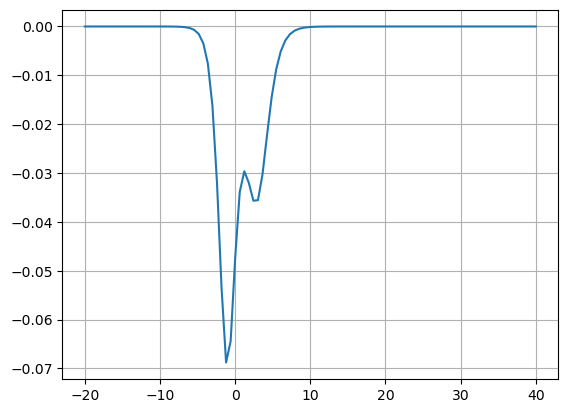

In [6]:
number_of_sample = 100
x_train = np.linspace(-20, 40, number_of_samples)
plt.plot(x_train, init_kdv(x_train))
plt.grid()

In [7]:
initCD = torch.from_numpy(init_kdv(x_train))
#initCD

### Compute the initial parameter $\theta_0$

In [13]:
torch.manual_seed(0)
d = 1
m = 5
model = ShallowExp(d, m)

x_train = np.linspace(-20, 40, number_of_samples)
x_train = torch.from_numpy(x_train).unsqueeze(1)
#print(xspace)
y_true = initCD
y_pred = model(x_train) # vectorized version
#y_pred

In [14]:
criterion=torch.nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

print('param-c', model.c)
print('param-b', model.b)
print('param-w', model.w)

num_epochs=1000

total_acc, total_loss=[], []

for epoch in range(num_epochs):
    y_pred=model(x_train)
    loss = criterion(y_pred,y_true)
    loss.backward(retain_graph=True) # back propagation
    optimizer.step()
    optimizer.zero_grad()
print(loss)

print('\nTraining Complete')

print('param-c', model.c)
print('param-b', model.b)
print('param-w', model.w)


param-c Parameter containing:
tensor([0.3489, 0.4017, 0.0223, 0.1689, 0.2939], requires_grad=True)
param-b Parameter containing:
tensor([[0.6341],
        [0.4901],
        [0.8964],
        [0.4556],
        [0.6323]], requires_grad=True)
param-w Parameter containing:
tensor([0.4963, 0.7682, 0.0885, 0.1320, 0.3074], requires_grad=True)
tensor(2.5307e-07, dtype=torch.float64, grad_fn=<MseLossBackward0>)

Training Complete
param-c Parameter containing:
tensor([ 0.1138,  0.0793, -0.1861, -0.0558,  0.0527], requires_grad=True)
param-b Parameter containing:
tensor([[1.1735],
        [0.0353],
        [0.5409],
        [1.0481],
        [0.9064]], requires_grad=True)
param-w Parameter containing:
tensor([0.7292, 0.9485, 0.5339, 0.3010, 0.5011], requires_grad=True)


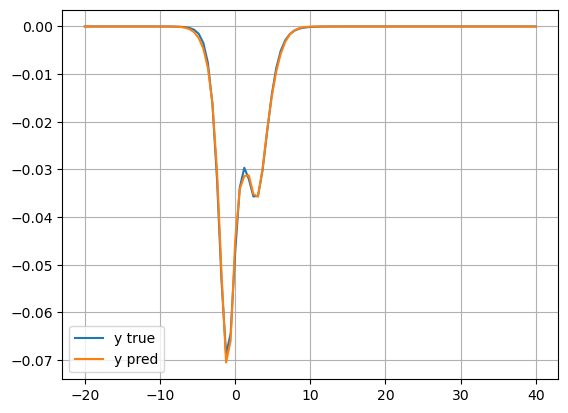

In [15]:
if d==1:
    xv = torch.linspace(-20., 40., 100)
    y_pred = model(xv.unsqueeze(1)).detach().numpy()
    plt.plot(xv.numpy(), y_true, label='y true')
    plt.plot(xv.numpy(), y_pred, label='y pred')
    plt.legend()
    plt.grid()
else:
    print("Warning: Plot for d>1 not supported.")

## Compute M and F

In [11]:
### Initiate the Metropolis Hasting Algorithm

In [12]:

# Number of samples to generate
num_samples = 
dimension_samples = d
# Initial state of the Markov chain
initial_state = torch.zeros(dimension_samples)
    # Target distribution : normal_law
def target_distribution(x):
    """Target distribution: a standard Gaussian."""
    return torch.exp(-0.5 * x**2) / torch.sqrt(2 * torch.tensor(3.141592653589793))

    # Proposal distribution: a normal law with mean x and standard deviation 'sigma'
def proposal_distribution(x):
    """Proposal distribution: a Gaussian with mean x and standard deviation sigma."""
    sigma = 0.5
    return dist.Normal(x, sigma)

    # Create the sampler instance
NN = ShallowExp(d, m)
target_distribution = targetDistribution(NN)

sampler = MetropolisHastingsSampler(num_samples, initial_state, target_distribution.value, proposal_distribution)
    # Run Metropolis-Hastings algorithm
samples, acceptance_rate = sampler.metropolis_hastings()


# Contruct estimF
theta = ParameterNN(nn.Parameter(torch.ones(m)),
                    nn.Parameter(torch.ones(m, d)),
                    nn.Parameter(torch.ones(m)))

Mapprox = estimM(NN, 2, samples)
print('all', Mapprox.evaluate(theta))

NameError: name 'm' is not defined